In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Code for Gauss-Siedel implementation for 2D Poisson in a rectangular.

In [2]:
def per(i,N):
    if i<0:
        i+=N
    elif i>=N:
        i -= N
    return i

def gauss_siedel_2D(charge_density , x_bound = [0,1] , boundary_cond_x = [lambda y: 0*y]*2 , 
                    y_bound = [0,1] , boundary_cond_y = [lambda x: 0*x]*2 ,
                    bound_cond_type = 'dirichlet',
                    Nx=10 , Ny = 10,
                    tol=1e-3 , w = 1,Faraday = False):

    x_vals = np.linspace(x_bound[0] , x_bound[-1] , Nx)
    y_vals = np.linspace(y_bound[0] , y_bound[-1] , Ny)
    
    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    x_vals_grid , y_vals_grid = np.meshgrid(x_vals, y_vals)
    
    rho = charge_density(x_vals_grid , y_vals_grid)  
    #
    phi = np.zeros((len(x_vals) , len(y_vals)))

    mask = np.zeros((Nx, Ny), dtype=bool)
    
    if Faraday == True:

        a = Nx // 2

        x_start = (Nx - a) // 2
        x_finish = (Nx + a) // 2
        
        y_start = (Ny - a) // 2
        y_finish = (Ny + a) // 2
        
        mask = np.zeros((Nx,Ny) , dtype = bool)
        mask[x_start,y_start:y_finish] = True
        mask[x_finish,y_start:y_finish+1] = True
        mask[x_start:x_finish,y_finish] = True
        mask[x_start:x_finish,y_start] = True

    if bound_cond_type == 'dirichlet':
        #
        phi[0,:] = boundary_cond_y[0](x_vals)
        phi[-1,:] = boundary_cond_y[-1](x_vals)
        phi[:,0] = boundary_cond_x[0](y_vals)
        phi[:,-1] = boundary_cond_x[-1](y_vals)
        #        
        E = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
        Es =[E]
        dE = 1
        #
        while abs(dE) >= tol:
            for i in range(1, Nx-1):
                for j in range(1,Ny-1):
                    if not mask[i,j]:
                        phi[i,j] = (1-w) * phi[i,j] + w/4 * (phi[i + 1 , j] + phi[i - 1 , j] + phi[i , j + 1] + phi[i , j - 1] + rho[i,j]*dx**2)
            E_prime = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
            dE = E_prime - E
            E = E_prime
            Es.append(E)
        Es = np.array(Es)

    if bound_cond_type == 'neuman':
        #
        phi[0,:] = phi[1,:] - dx * boundary_cond_y[0](x_vals)
        phi[-1,:] = phi[-2,:] + dx * boundary_cond_y[-1](x_vals)
        phi[:,0] = phi[:,1] - dy * boundary_cond_x[0](y_vals)
        phi[:,-1] = phi[:,-2] + dy * boundary_cond_x[-1](y_vals)
        #
        E = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
        Es =[E]
        dE = 1
        #
        while abs(dE) >= tol:
            for i in range(1, Nx - 1):
                for j in range(1,Ny-1):
                    if not mask[i,j]:
                        phi[i,j] = (1-w) * phi[i,j] + w/4 * (phi[i + 1 , j] + phi[i - 1 , j] + phi[i , j + 1] + phi[i , j - 1] + rho[i,j]*dx**2)
            #  
            phi[0,:] = phi[1,:] - dx * boundary_cond_y[0](x_vals)
            phi[-1,:] = phi[-2,:] + dx * boundary_cond_y[-1](x_vals)
            phi[:,0] = phi[:,1] - dy * boundary_cond_x[0](y_vals)
            phi[:,-1] = phi[:,-2] + dy * boundary_cond_x[-1](y_vals)
            #
            E_prime = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
            dE = E_prime - E
            E = E_prime
            Es.append(E)
        Es = np.array(Es)  

    if bound_cond_type == 'periodic':
        #
        E = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
        Es =[E]
        dE = 1
        #
        while abs(dE) >= tol:
            for i in range(1, Nx - 1):
                for j in range(1,Ny-1):
                    if not mask[i,j]:
                        phi[i,j] = (1-w) * phi[i,j] + w/4 * (phi[ per(i + 1 , Nx) , j] + phi[ per(i - 1 , Nx) , j] +\
                                                         phi[i , per(j + 1 , Ny) ] + phi[i , per(j - 1 , Ny) ] +\
                                                         rho[i,j]*dx**2)
            E_prime = 1/2 * np.sum( np.diff(phi , axis=0)[:,:-1]**2 + np.diff(phi , axis=1)[:-1,:]**2 ) - dx**2 * np.sum(rho * phi)
            dE = E_prime - E
            E = E_prime
            Es.append(E)
        Es = np.array(Es)

    return x_vals_grid , y_vals_grid , phi , Es

### Functions for charge densities

In [3]:
def step(y,y_o):
    return np.array(y < y_o, dtype=int)

def capacitor_plack(x,y , xf , xi , yf, yi):
    return (step(y,yf) - step(y,yi)) * (step(x,xf) - step(x,xi))

def gauss(x,y,s,mx,my,q):
    return q / (s * np.sqrt(2*np.pi)) * np.exp( - ( (x - mx)**2 + (y-my)**2 )/ s**2)

In [4]:
# example


charge_density = lambda x,y: gauss(x,y,1,-2,-2,1) + gauss(x,y,1,2,2,-1)

# rectangular boundary 
x_bound = [-10,10]
y_bound = [-10,10]

# boundary conditions
boundary_cond_x = [lambda y: 0 , lambda y: 0]
boundary_cond_y = [lambda x: 0, lambda x: 0]
bound_cond_type = 'dirichlet'

# mesh size
Nx = 80
Ny = 80

# params
tol = 1e-17
w = 1.5

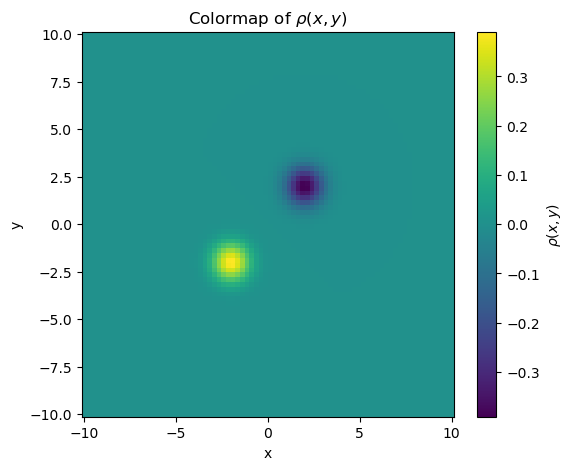

In [5]:
x, y = np.meshgrid(np.linspace(x_bound[0],x_bound[-1],Nx) ,np.linspace(y_bound[0],y_bound[-1],Ny) )
plt.figure(figsize=(6, 5))
plt.pcolormesh(x, y, charge_density(x,y), cmap='viridis', shading='auto')
plt.colorbar(label=r'$\rho(x,y)$')  # Add color scale
plt.xlabel("x")
plt.ylabel("y")
plt.title(r'Colormap of $\rho(x,y)$')
plt.show()

### Solve Poisson

In [6]:
xs , ys , phi , Es = gauss_siedel_2D(charge_density,
                           x_bound = x_bound ,
                           boundary_cond_x = boundary_cond_x,
                           y_bound = y_bound,
                           boundary_cond_y = boundary_cond_y,
                           bound_cond_type = bound_cond_type,
                           Nx = Nx,
                           Ny = Ny,
                           tol = tol,
                           w = w, Faraday = True)

### Results

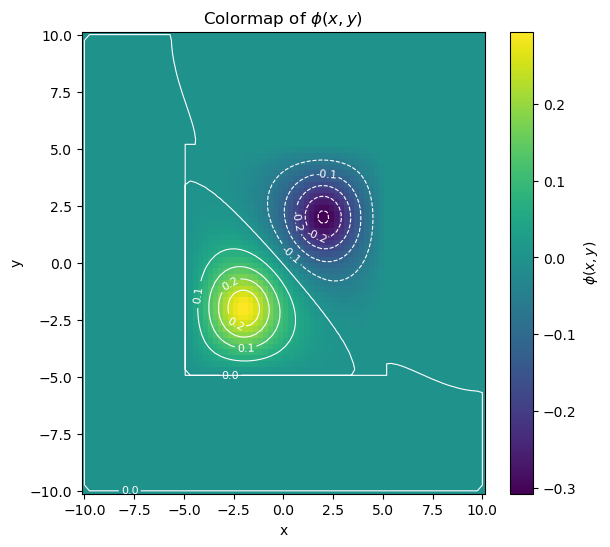

-0.2914140270267971

In [7]:
plt.figure(figsize=(6.5, 6))

contour_levels = 10  # Adjust the number of contour lines if needed
contours = plt.contour(xs, ys, phi, levels=contour_levels, colors='white', linewidths=0.8)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.1f", colors='white')


plt.pcolormesh(xs, ys, phi, cmap='viridis', shading='auto')

plt.colorbar(label=r'$\phi(x,y)$')  # Add color scale
plt.xlabel("x")
plt.ylabel("y")
plt.title(r'Colormap of $\phi(x,y)$')
plt.show()
Es[-1]

In [8]:
Ey = - np.array(np.gradient(phi))[0] # y der
Ex = - np.array(np.gradient(phi))[1] # x der

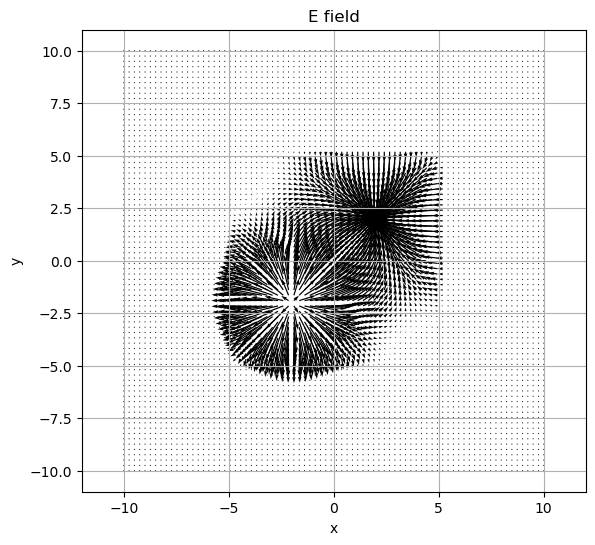

In [9]:
plt.figure(figsize=(6.5,6))
plt.quiver(xs, ys, Ex, Ey, scale=.5, color="black")

# Formatting
plt.xlabel("x")
plt.grid()
plt.ylabel("y")
plt.title("E field")
plt.axis("equal")  # Ensures equal aspect ratio

plt.show()

### Check 

In [10]:
dEydy , dExdx = np.array(np.gradient(Ey))
divE = dExdx + dEydy
print(f'divE = ρ/ε_ο (theoretically)\nMSE = {np.mean((divE - charge_density(xs,ys))**2)}')

divE = ρ/ε_ο (theoretically)
MSE = 0.001142773998285259


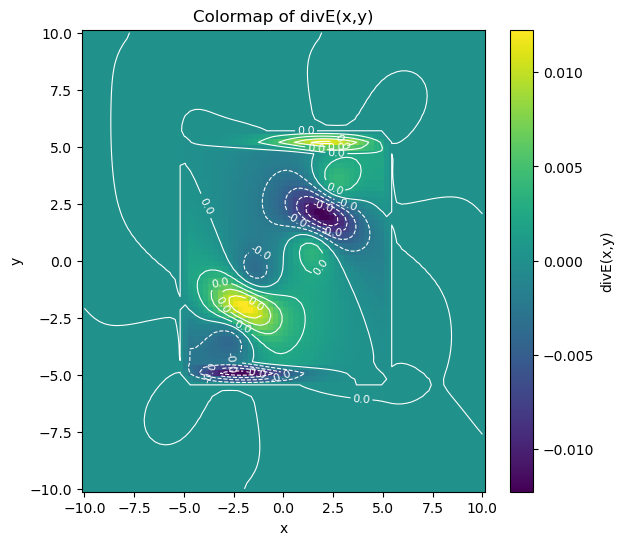

In [11]:
plt.figure(figsize=(6.5, 6))

contour_levels = 10  # Adjust the number of contour lines if needed
contours = plt.contour(xs, ys, divE, levels=contour_levels, colors='white', linewidths=0.8)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.1f", colors='white')


plt.pcolormesh(xs, ys, divE, cmap='viridis', shading='auto')

plt.colorbar(label=r'divE(x,y)')  # Add color scale
plt.xlabel("x")
plt.ylabel("y")
plt.title(r'Colormap of divE(x,y)')
plt.show()

### EOF